# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: 05.10.2019

Мягкий дедлайн: 07:59MSK 15.10.2019 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.10.2019

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

** Задание 1 (1 балл)** Градиентного спуска;

** Задание 2 (1.5 балла)** Стохастического градиентного спуска;

** Задание 3 (2.5 балла)** Метода Momentum.


Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [5]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

class LinearRegBase(BaseEstimator):
    def __init__(
        self, tolerance=1e-4, max_iter=1000, w0=None,
        alpha=1e-3, eta=1e-2, batch_size=1, logging_period=100, verbose=True, adam_b1=0.9, adam_b2=0.999):
        """
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        w: weights after training
        eta: learning rate
        alpha: momentum coefficient
        batch_size: for stochastic, size of a batch.
        logging_period: frequency of loss logging
        """
        self.tolerance = tolerance
        self.momentum_velocity = 0
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.batch_size = batch_size
        self.loss_history = None # list of loss function values at each training iteration
        self.verbose = verbose
        self.logging_period = logging_period
        self.adam_param1, self.adam_param2 = 0, 0
        self.adam_b1, self.adam_b2 = adam_b1, adam_b2
        
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        ell, d = X.shape
        if not self.w0:
            old_w = np.zeros(d,)
            self.w = np.zeros(d,)
        else:
            old_w = self.w0
            self.w = self.w0
        self.loss_history = []
        for i in range(self.max_iter):
            old_w, self.w = self.w, self.iterate(X, y)
            self.loss_history.append(self.calc_loss(X, y))
            if i % self.logging_period == 0:
                if self.verbose:
                    print(i, self.calc_loss(X, y))
            if np.linalg.norm(self.w - old_w) < self.tolerance:
                return self
        return self
    
    def iterate(self, X, y):
        raise NotImplementedError()
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return X.dot(self.w)
    
    def get_losses(self):
        return self.loss_history
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        return 2 * X.T.dot(X.dot(self.w) - y) / y.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        return mean_squared_error(self.predict(X), y)

In [6]:
class LinearRegGradientDescent(LinearRegBase):
    def iterate(self, X, y):
        return self.w - (self.eta * self.calc_gradient(X, y))

In [30]:
class LinearRegStochasticGradientDescent(LinearRegBase):
    def iterate(self, X, y):
        sample = np.random.randint(X.shape[0], size=self.batch_size)
        return self.w - (self.eta * self.calc_gradient(X[sample], y[sample]))

In [4]:
class LinearRegMomentum(LinearRegBase):
    def iterate(self, X, y):
        self.momentum_velocity = self.alpha * self.momentum_velocity + self.eta * self.calc_gradient(X, y)
        return self.w - self.momentum_velocity


In [5]:
class LinearRegAdam(LinearRegBase):
    def iterate(self, X, y):
        self.adam_param1 = self.adam_b1 * self.adam_param1 + (1 - self.adam_b1) * self.calc_gradient(X, y)
        self.adam_param2 = self.adam_b2 * self.adam_param2 + (1 - self.adam_b2) * np.power(self.calc_gradient(X, y), 2)
        return self.w - self.eta * self.adam_param1 / (np.sqrt(self.adam_param2) +1e-10)


** Задание 4 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from haversine import haversine
import matplotlib.pyplot as plt

In [8]:
def get_dataframe_for_gradient():
    dataframe = pd.read_csv('train.csv')
    dataframe.drop('dropoff_datetime', axis=1, inplace=True)
    dataframe['pickup_datetime'] = pd.to_datetime(dataframe['pickup_datetime'])
    dataframe['log_trip_duration'] = np.log1p(dataframe['trip_duration'])
    dataframe['weekday'] = dataframe['pickup_datetime'].dt.weekday
    dataframe['day'] = dataframe['pickup_datetime'].dt.day
    dataframe['month'] = dataframe['pickup_datetime'].dt.month
    dataframe['hour'] = dataframe['pickup_datetime'].dt.hour
    dataframe['dayofyear'] = dataframe['pickup_datetime'].dt.dayofyear
    dataframe['is_anomalous_1'] = (dataframe.month == 1) & ((dataframe.day == 23) | (dataframe.day == 24))
    dataframe['is_anomalous_2'] = (dataframe.month == 5) & (dataframe.day == 30)
    dataframe['is_anomalous_3'] = (dataframe.month == 1) & ((dataframe.day == 25) | (dataframe.day == 26))
    dataframe['is_anomalous_4'] = (dataframe.month == 1) & (dataframe.day == 27)
    dataframe[['is_anomalous_%d' % i for i in range(1, 5)]] = dataframe[[
        'is_anomalous_%d' % i for i in range(1, 5)]].astype(int)

    dataframe['empty_roads'] = (
          (dataframe.hour == 5)
        | ((dataframe.hour == 4) & (dataframe.weekday <= 3))
        | ((dataframe.hour == 6) & (dataframe.weekday >= 5))
        | ((dataframe.hour == 3) & ((dataframe.weekday == 1) | (dataframe.weekday == 3)))
    )

    dataframe['busy_roads'] = (
          (((dataframe.hour <= 15) & (dataframe.hour >= 9)) & ((dataframe.weekday >= 1) | (dataframe.weekday <= 3)))
        | (((dataframe.hour <= 11) & (dataframe.hour >= 9)) & (dataframe.weekday == 4))
    )

    row_modifier = lambda p_lat, p_lon, d_lat, d_lon: haversine((p_lat, p_lon), (d_lat, d_lon))

    dataframe['haversine'] = np.vectorize(row_modifier)(dataframe.pickup_latitude, dataframe.pickup_longitude, 
        dataframe.dropoff_latitude, dataframe.dropoff_longitude)
    dataframe['log_haversine'] = np.log1p(dataframe['haversine'])

    row_modifier = lambda p_lat, p_lon, d_lat, d_lon: haversine((p_lat, p_lon), (d_lat, d_lon))

    LA_GUARDIA_LAT = 40.7769
    LA_GUARDIA_LON = -73.8740
    J_KENNEDY_LAT = 40.6413
    J_KENNEDY_LON = -73.7781
    dataframe['pickup_distance_from_la_guardia'] = np.vectorize(row_modifier)(dataframe.pickup_latitude, dataframe.pickup_longitude, 
        LA_GUARDIA_LAT, LA_GUARDIA_LON)
    dataframe['pickup_distance_from_j_kennedy'] = np.vectorize(row_modifier)(dataframe.pickup_latitude, dataframe.pickup_longitude, 
        J_KENNEDY_LAT, J_KENNEDY_LON)
    dataframe['dropoff_distance_from_la_guardia'] = np.vectorize(row_modifier)(dataframe.dropoff_latitude, dataframe.dropoff_longitude, 
        LA_GUARDIA_LAT, LA_GUARDIA_LON)
    dataframe['dropoff_distance_from_j_kennedy'] = np.vectorize(row_modifier)(dataframe.dropoff_latitude, dataframe.dropoff_longitude, 
        J_KENNEDY_LAT, J_KENNEDY_LON)
    dataframe['pickup_from_la_guardia'] = dataframe['pickup_distance_from_la_guardia'] < 1.5

    dataframe['pickup_from_la_guardia_zone1'] = dataframe['pickup_distance_from_la_guardia'] < 0.6
    dataframe['pickup_from_la_guardia_zone2'] = \
            (dataframe['pickup_distance_from_la_guardia'] >= 0.6) \
            & (dataframe['pickup_distance_from_la_guardia'] < 1.5)
    dataframe['dropoff_from_la_guardia'] = dataframe['dropoff_distance_from_la_guardia'] < 1.6

    dataframe['dropoff_from_la_guardia_zone1'] = dataframe['dropoff_distance_from_la_guardia'] < 0.75
    dataframe['dropoff_from_la_guardia_zone2'] = \
            (dataframe['dropoff_distance_from_la_guardia'] >= 0.75) \
            & (dataframe['dropoff_distance_from_la_guardia'] < 1.25)
    dataframe['dropoff_from_la_guardia_zone3'] = \
            (dataframe['dropoff_distance_from_la_guardia'] >= 1.25) \
            & (dataframe['dropoff_distance_from_la_guardia'] < 1.6)
    dataframe['pickup_from_j_kennedy'] = dataframe['pickup_distance_from_j_kennedy'] < 1.3

    dataframe['pickup_from_j_kennedy_zone1'] = dataframe['pickup_distance_from_j_kennedy'] < 0.63
    dataframe['pickup_from_j_kennedy_zone2'] = \
            (dataframe['pickup_distance_from_j_kennedy'] >= 0.63) \
            & (dataframe['pickup_distance_from_j_kennedy'] < 1.3)
    dataframe['dropoff_from_j_kennedy'] = dataframe['dropoff_distance_from_j_kennedy'] < 1.5

    dataframe['dropoff_from_j_kennedy_zone1'] = dataframe['dropoff_distance_from_j_kennedy'] < 0.75
    dataframe['dropoff_from_j_kennedy_zone2'] = \
            (dataframe['dropoff_distance_from_j_kennedy'] >= 0.75) \
            & (dataframe['dropoff_distance_from_j_kennedy'] < 1.5)
    return dataframe

In [9]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

def r_square(y_true, y_pred):
    return 1 - rmse(y_true, y_pred) / np.var(y_true)

In [10]:
dataframe = get_dataframe_for_gradient()

In [11]:
y = dataframe["log_trip_duration"]
X = dataframe.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

** Задание 5 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` (`max_iter`, `alpha` и `eta` для Momentum) на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

Влияние max_iter - влияние количества итераций, а значит, будет отражено в следующем задании.

In [12]:
categorical_features = ['weekday', 'month', 'dayofyear', 'hour']
numeric_features = [
    'is_anomalous_1', 'is_anomalous_2', 'is_anomalous_3', 'is_anomalous_4', 'empty_roads', 'busy_roads',
    'pickup_from_j_kennedy', 'dropoff_from_j_kennedy', 'pickup_from_la_guardia', 'dropoff_from_la_guardia',
    'log_haversine',
]
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

MAX_ITER = 1000
TOLERANCE = 1e-5

Сначала просто посмотрим на то, что получается при обучении различных спусков.

In [23]:
simple_gradient_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegGradientDescent(tolerance=TOLERANCE, max_iter=MAX_ITER))
])
simple_gradient_model = simple_gradient_pipeline.fit(X_train, y_train)

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
100 9.862404447965147
200 2.499568330866332
300 0.7859667584214434
400 0.3836572837423518
500 0.2869985894408831
600 0.2622860662191136
700 0.25493226929398277
800 0.25203280048803806
900 0.2504474840898189


In [24]:
y_pred = simple_gradient_model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R^2 = %.4f" % r_square(y_test, y_pred))

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


Test RMSE = 0.4957
Test R^2 = 0.2127


Видим, что модель обучилась достаточно быстро и хорошо (сравниваем с Ridge).

Исследуем зависимость от eta и номера итерации.

In [49]:
pows = np.linspace(-4, -1, num=5)
etas = np.power(10, pows)
iterations = np.arange(MAX_ITER)
simple_gradient_pipelines = [Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegGradientDescent(tolerance=1e-5, max_iter=MAX_ITER, eta=eta, verbose=False))
]) for eta in etas]

In [50]:
simple_gradient_models = [pipeline.fit(X_train, y_train) for pipeline in simple_gradient_pipelines[1:]]

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sk

In [51]:
simple_gradient_losses = [model.named_steps.regression.get_losses() for model in simple_gradient_models]

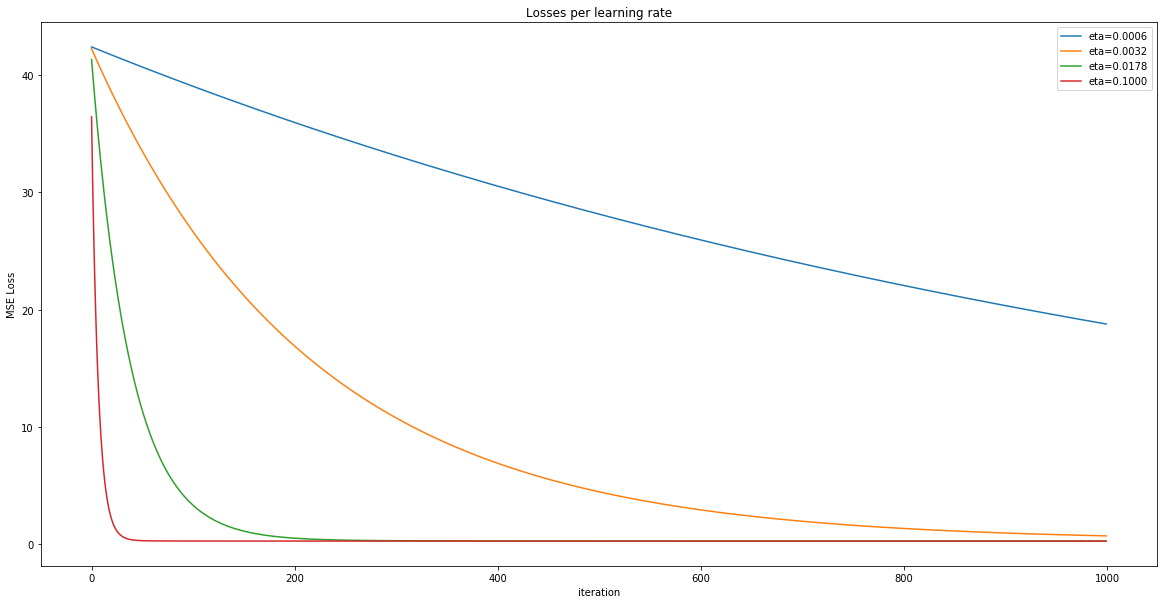

In [56]:
plt.figure(figsize=(20,10))
for i in range(len(etas) - 1):
    plt.plot(simple_gradient_losses[i], label='eta=%.4f' % etas[i + 1])

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Losses per learning rate')
plt.legend()
plt.show()

In [60]:
stochastic_gradient_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegStochasticGradientDescent(
        tolerance=TOLERANCE, max_iter=3000, batch_size=20000, logging_period=100, eta=1e-1))
])
stochastic_gradient_model = stochastic_gradient_pipeline.fit(X_train, y_train)

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 42.332872176014135
100 31.778959288117594
200 23.922941598397273
300 18.0432798506705
400 13.629472338135551
500 10.314187213064098
600 7.822672289456475
700 5.949445067496388
800 4.5412967485740205
900 3.4821471076532626
1000 2.6859756321129216
1100 2.08691428300284
1200 1.6362414078119993
1300 1.297004130301648
1400 1.041575035911516
1500 0.8492797544858445
1600 0.7043953703001461
1700 0.5951723920104519
1800 0.5128124581079203
1900 0.4505707618640584
2000 0.40359494508143334
2100 0.36806378133188516
2200 0.341098330121499
2300 0.32058969602967397
2400 0.3050247175009097
2500 0.29314250109187295
2600 0.2840943496918868
2700 0.2771344471332009
2800 0.27175524048621374
2900 0.26759367353746394


In [61]:
y_pred = stochastic_gradient_model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R^2 = %.4f" % r_square(y_test, y_pred))

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


Test RMSE = 0.5105
Test R^2 = 0.1892


Видим, что модель учится медленно (что логично, так как батчи),

In [71]:
pows = np.linspace(-1, -0.2, num=5)
etas = np.power(10, pows)
iterations = np.arange(MAX_ITER)
stochastic_gradient_pipelines = [Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegStochasticGradientDescent(tolerance=1e-5, max_iter=3000, batch_size=20000, eta=eta, verbose=False))
]) for eta in etas]

In [72]:
stochastic_gradient_models = [pipeline.fit(X_train, y_train) for pipeline in stochastic_gradient_pipelines]

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sk

In [74]:
stochastic_gradient_losses = [model.named_steps.regression.get_losses() for model in stochastic_gradient_models]

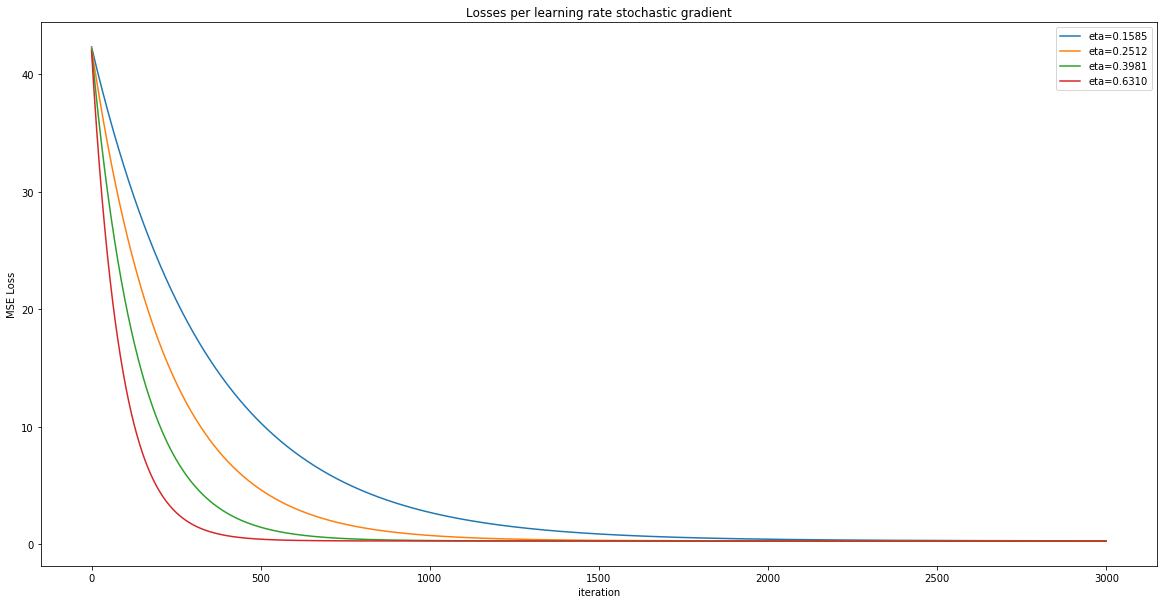

In [75]:
plt.figure(figsize=(20,10))
for i in range(len(etas) - 1):
    plt.plot(stochastic_gradient_losses[i], label='eta=%.4f' % etas[i + 1])

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Losses per learning rate stochastic gradient')
plt.legend()
plt.show()

In [35]:
momentum_gradient_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegMomentum(tolerance=TOLERANCE, max_iter=500, alpha=0.5))
])
momentum_gradient_model = momentum_gradient_pipeline.fit(X_train, y_train)

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
100 2.4130620583063567
200 0.3727354662661319
300 0.261336831088397
400 0.25194045192350945


Видим, что сходитсяя быстро

In [36]:
y_pred = momentum_gradient_model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R^2 = %.4f" % r_square(y_test, y_pred))

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


Test RMSE = 0.4957
Test R^2 = 0.2127


In [12]:
pows = np.linspace(-4, -1, num=5)
etas = np.power(10, pows)
iterations = np.arange(MAX_ITER)
momentum_gradient_pipelines = [Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegMomentum(tolerance=1e-5, eta=eta, verbose=False, max_iter=500))
]) for eta in etas]

In [13]:
momentum_gradient_models = [pipeline.fit(X_train, y_train) for pipeline in momentum_gradient_pipelines]

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sk

In [14]:
momentum_gradient_losses = [model.named_steps.regression.get_losses() for model in momentum_gradient_models]

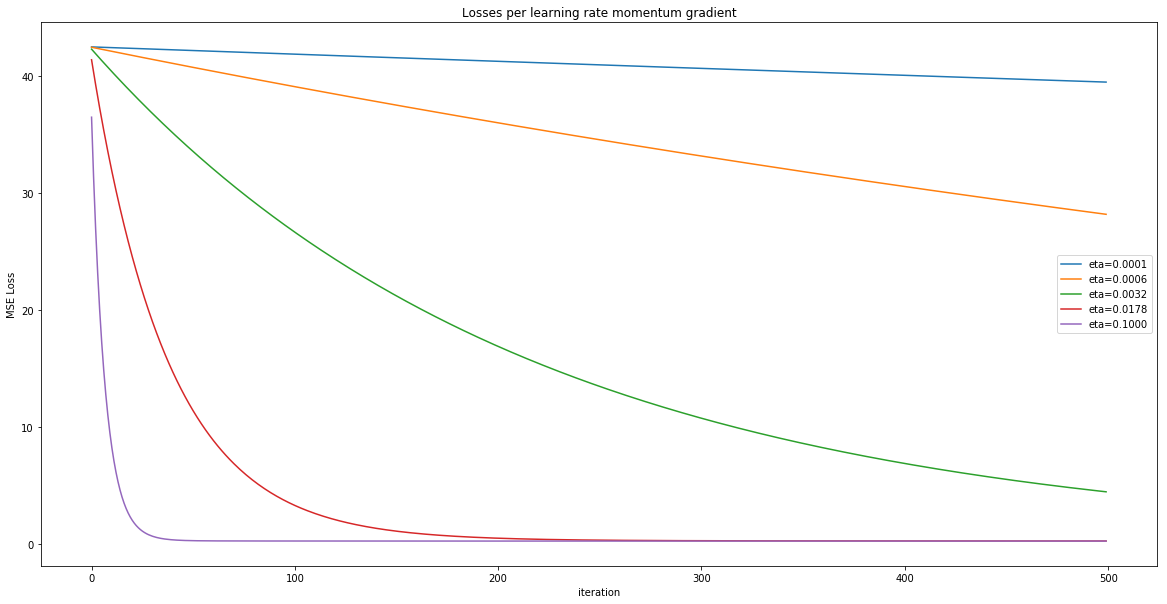

In [15]:
plt.figure(figsize=(20,10))
for i in range(len(etas)):
    plt.plot(momentum_gradient_losses[i], label='eta=%.4f' % etas[i])

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Losses per learning rate momentum gradient')
plt.legend()
plt.show()

In [18]:
pows = np.linspace(-4, -1, num=5)
alphas = np.linspace(0, 1, num=5)
iterations = np.arange(MAX_ITER)
momentum_gradient_pipelines = [Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegMomentum(tolerance=1e-5, alpha=alpha, eta=0.01, logging_period=30, max_iter=500))
]) for alpha in alphas]

In [19]:
momentum_gradient_models = [pipeline.fit(X_train, y_train) for pipeline in momentum_gradient_pipelines]

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
30 26.969685375951617
60 17.477576556657315
90 11.370547878618753
120 7.433633753454052
150 4.893960376345842
180 3.254979803262802
210 2.19685001899393
240 1.5133966639486467
270 1.0716798094284519
300 0.7859667584214434
330 0.600960902724654
360 0.48099114976833324
390 0.40304242188346995
420 0.3522620394095667
450 0.3190622142097275
480 0.2972515800884386


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
30 23.305719676243427
60 13.069978051728834
90 7.389044896594191
120 4.230959697980408
150 2.474078342564881
180 1.4959529673275063
210 0.9508146507448487
240 0.6465239132917726
270 0.476283672777121
300 0.38071522629410043
330 0.3267915643551433
360 0.2961331237774607
390 0.2785042203136222
420 0.2681987149344696
450 0.2620309720312603
480 0.25821884593617633


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
30 17.463433420137715
60 7.309754846233876
90 3.155058617121685
120 1.452008875623938
150 0.7522931947474947
180 0.463627295478633
210 0.34364214374012936
240 0.2930745304892342
270 0.2712165788316795
300 0.2613368310883969
330 0.25653240361277646
360 0.25393686332460685
390 0.25234662682465164
420 0.2512467194195821
450 0.2504098456768765
480 0.24973066823400766


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
30 7.242617678650943
60 1.2428263856464667
90 0.4010323476150689
120 0.2786569522092889
150 0.2582954488901296
180 0.2532870377593464
210 0.25108284206408105
240 0.24967075470477432
270 0.2486266252965019
300 0.24780968340899262
330 0.24715108078862036
360 0.2466095978118083
390 0.24615794664904603
420 0.245776912754261
450 0.2454523686978452
480 0.2451736001453873


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
30 34.31834080338319
60 11.449825198781616
90 0.6055307814589383
120 14.748102934248182
150 36.719471203892425
180 40.4322910393421
210 21.156616592331275
240 1.9538528971566511
270 6.24836664005875
300 28.714681170566667
330 42.217920029110005
360 30.819128387623948
390 8.168007989286272
420 1.3610043647901453
450 18.62757322828328
480 39.48351740239485


In [22]:
momentum_gradient_losses = [model.named_steps.regression.get_losses() for model in momentum_gradient_models]

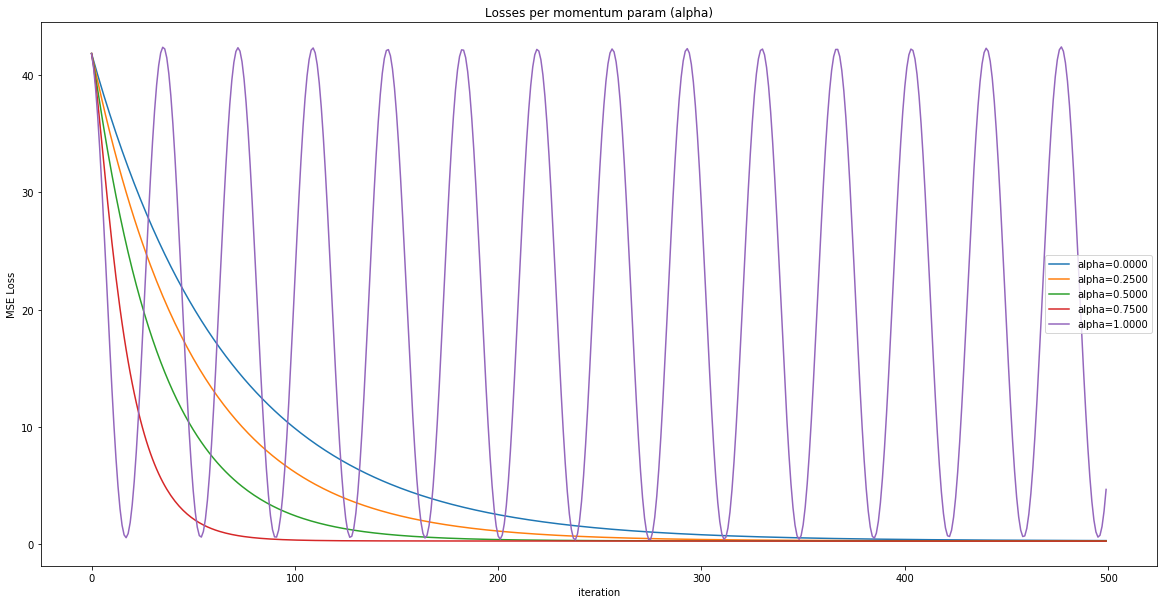

In [23]:
plt.figure(figsize=(20,10))
for i in range(len(alphas)):
    plt.plot(momentum_gradient_losses[i], label='alpha=%.4f' % alphas[i])

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Losses per momentum param (alpha)')
plt.legend()
plt.show()

In [52]:
adam_gradient_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegAdam(tolerance=1e-10, max_iter=500))
])
adam_gradient_model = adam_gradient_pipeline.fit(X_train, y_train)

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 40.77210300552238
100 0.24375425413470328
200 0.24213551764467228
300 0.24205138063669596
400 0.2420325236697349


In [53]:
y_pred = adam_gradient_model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Test R^2 = %.4f" % r_square(y_test, y_pred))

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


Test RMSE = 0.4883
Test R^2 = 0.2245


In [56]:
pows = np.linspace(-4, -1, num=5)
etas = np.power(10, pows)
iterations = np.arange(MAX_ITER)
adam_gradient_pipelines = [Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegAdam(tolerance=1e-5, eta=eta, verbose=False, max_iter=300))
]) for eta in etas]

In [57]:
adam_gradient_models = [pipeline.fit(X_train, y_train) for pipeline in adam_gradient_pipelines]

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sk

In [58]:
adam_gradient_losses = [model.named_steps.regression.get_losses() for model in adam_gradient_models]

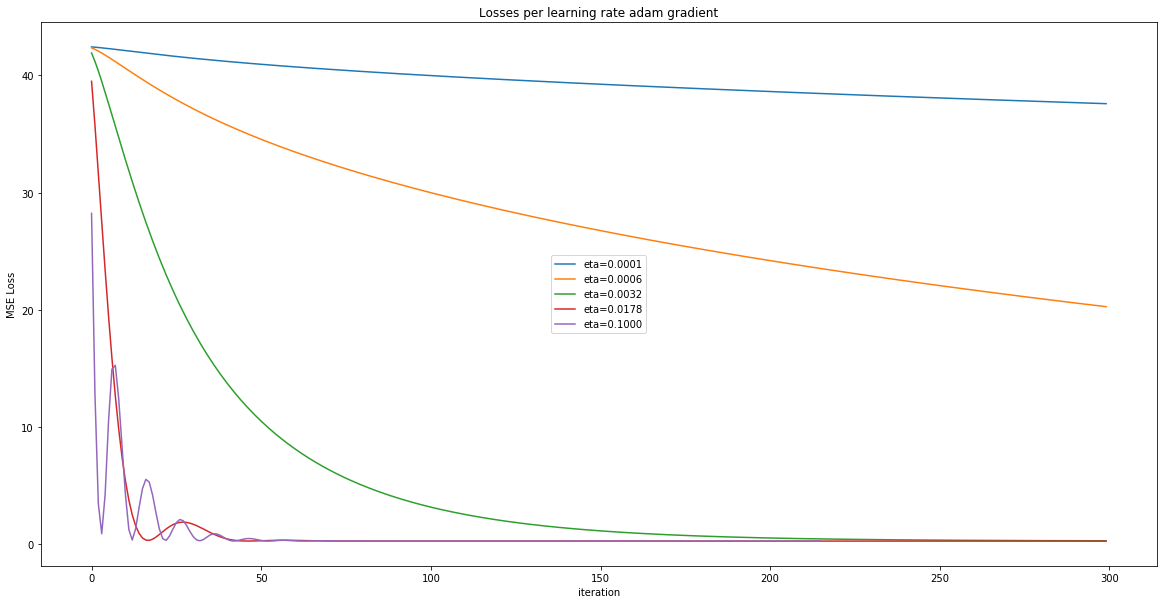

In [59]:
plt.figure(figsize=(20,10))
for i in range(len(etas)):
    plt.plot(adam_gradient_losses[i], label='eta=%.4f' % etas[i])

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Losses per learning rate adam gradient')
plt.legend()
plt.show()

In [66]:
betas1 = np.linspace(0, 1, num=5)
iterations = np.arange(MAX_ITER)
adam_gradient_pipelines = [Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegAdam(tolerance=1e-5, adam_b1=beta1, eta=0.01, logging_period=100, max_iter=300))
]) for beta1 in betas1]

In [67]:
adam_gradient_models = [pipeline.fit(X_train, y_train) for pipeline in adam_gradient_pipelines]

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 28.226919524245627
100 0.24225719541767693
200 0.24204520507047003


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 31.24143001284027
100 0.24229845156335053
200 0.2420486744566344


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 34.61768104039561
100 0.24238030144276626
200 0.2420567678226047


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 38.35567260691161
100 0.2425845242912276
200 0.24207913934310007


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 42.45540471238833


In [69]:
adam_gradient_losses = [model.named_steps.regression.get_losses() for model in adam_gradient_models]

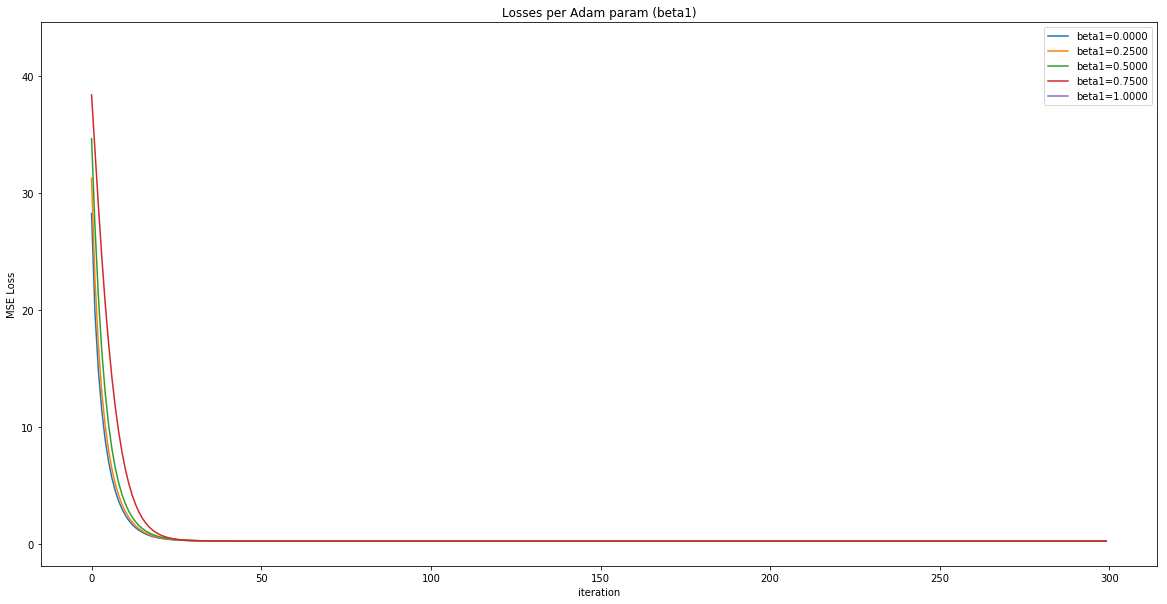

In [70]:
plt.figure(figsize=(20,10))
for i in range(len(betas1)):
    plt.plot(adam_gradient_losses[i], label='beta1=%.4f' % betas1[i])

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Losses per Adam param (beta1)')
plt.legend()
plt.show()

In [13]:
betas2 = np.linspace(0.2, 0.999, num=5)
iterations = np.arange(MAX_ITER)
adam_gradient_pipelines = [Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegAdam(tolerance=1e-5, adam_b2=beta2, eta=0.01, logging_period=100, max_iter=300))
]) for beta2 in betas2]

In [14]:
adam_gradient_models = [pipeline.fit(X_train, y_train) for pipeline in adam_gradient_pipelines]

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 42.394904026323175
100 6.49434444317368
200 0.2621044040339174


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 42.3855655377622
100 6.576056702014157
200 0.26666539774208875


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 42.36991837900796
100 6.722683147760853
200 0.2665339452888017


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 42.33470152458492
100 7.0425879882936115
200 0.24248157486553937


/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 40.77210300552238
100 0.24375425413470328
200 0.24213551764467228


In [15]:
adam_gradient_losses = [model.named_steps.regression.get_losses() for model in adam_gradient_models]

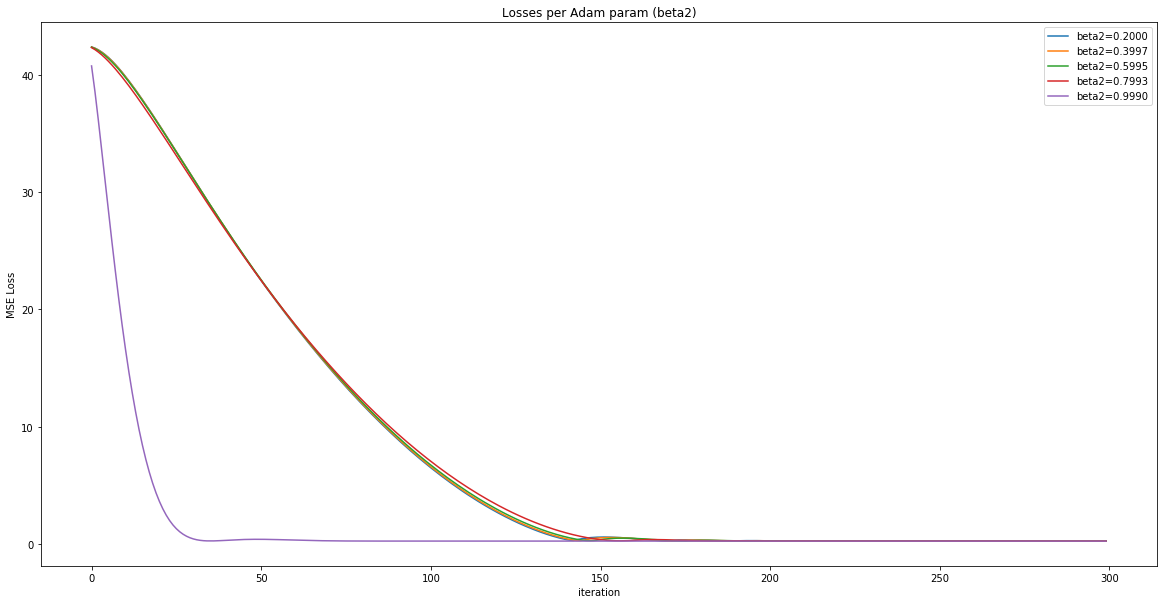

In [16]:
plt.figure(figsize=(20,10))
for i in range(len(betas2)):
    plt.plot(adam_gradient_losses[i], label='beta2=%.4f' % betas2[i])

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Losses per Adam param (beta2)')
plt.legend()
plt.show()

** Задание 6 (2 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

In [48]:
momentum_gradient_pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegMomentum(max_iter=300, tolerance=1e-5, eta=0.01, alpha=0.5, verbose=False))
])

simple_gradient_pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegGradientDescent(tolerance=1e-5, max_iter=300, eta=0.01, verbose=True))
])

stochastic_gradient_pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegStochasticGradientDescent(tolerance=1e-5, max_iter=300, batch_size=200, eta=0.01, verbose=True))
])

adam_gradient_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegAdam(tolerance=1e-5, max_iter=300, eta=0.01, verbose=False))
])

In [49]:
stochastic_gradient_models = stochastic_gradient_pipeline.fit(X_train, y_train)

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.81411332499422
100 9.852842918859391
200 2.504637215660777


In [50]:
simple_gradient_models = simple_gradient_pipeline.fit(X_train, y_train)

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0 41.832448267872515
100 9.862404447965147
200 2.499568330866332


In [51]:
momentum_gradient_models = momentum_gradient_pipeline.fit(X_train, y_train)
adam_gradient_models = adam_gradient_pipeline.fit(X_train, y_train)

/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nuwanda/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


In [52]:
momentum_gradient_losses = momentum_gradient_models.named_steps.regression.get_losses()
stochastic_gradient_losses = stochastic_gradient_models.named_steps.regression.get_losses()
simple_gradient_losses = simple_gradient_models.named_steps.regression.get_losses()
adam_gradient_losses = adam_gradient_models.named_steps.regression.get_losses()

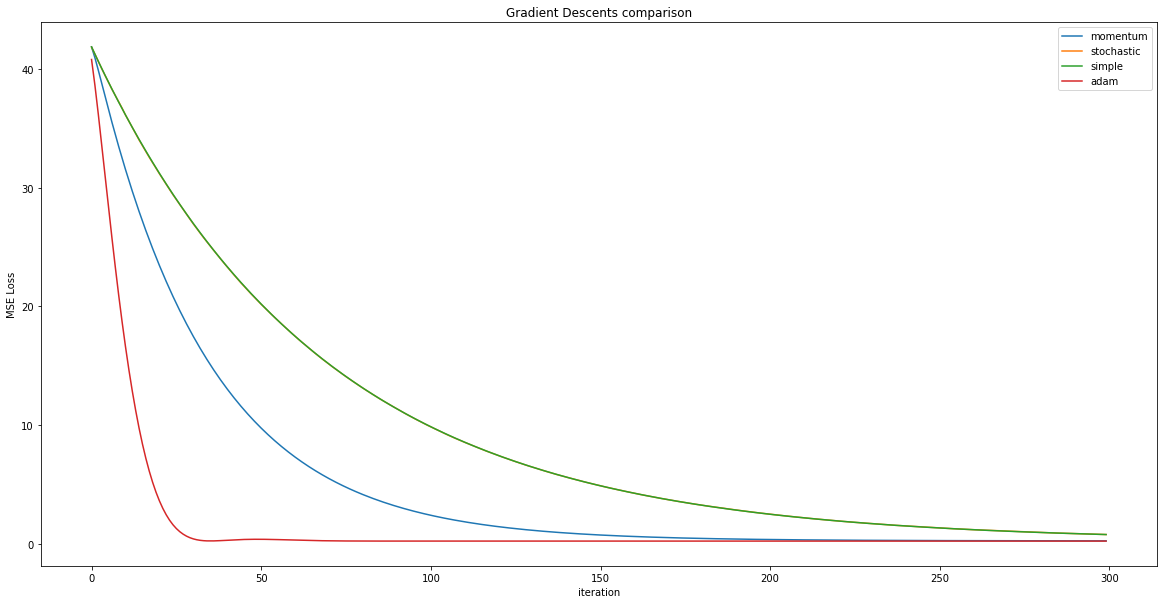

In [53]:
plt.figure(figsize=(20,10))

plt.plot(momentum_gradient_losses, label='momentum')
plt.plot(stochastic_gradient_losses, label='stochastic')
plt.plot(simple_gradient_losses, label='simple')
plt.plot(adam_gradient_losses, label='adam')

plt.xlabel("iteration")
plt.ylabel("MSE Loss")
plt.title('Gradient Descents comparison')
plt.legend()
plt.show()

### Бонус 

** Задание 7 (2 балла)**. Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью метода
[Adam](https://arxiv.org/pdf/1412.6980.pdf) - добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты. 

см выше

** Задание 8 (2 балла)**. Реализуйте линейную регрессию с функцией потерь
$$ L(\hat{y}, y) = log(cosh(\hat{y} - y)),$$

обучаемую с помощью градиентного спуска.

In [17]:
class LinearRegGradientDescentLogLosses(LinearRegGradientDescent):
    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        return np.mean(np.log(np.cosh(self.predict(X) - y)))

** Задание 9 (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook